# Data reduction


**Objective: Creating images of the SNR RX J1713.7-3946**


Here, we have to interact with the data archive (with the `~gammapy.data.DataStore`) to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the geometry of the `~gammapy.datasets.MapDataset` object we want to produce and the maker object that reduce an observation to a dataset. 

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Apply a `~gammapy.estimators.ExcessMapEstimator` to compute excess, significance and flux maps of the region.

## Setup
First, we setup the analysis by performing required imports.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker

from gammapy.modeling import Fit
from gammapy.estimators import ExcessMapEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [5]:
from astropy.coordinates import SkyCoord
target_position = SkyCoord(347.27, -0.45, unit="deg", frame="galactic")
print(target_position)

<SkyCoord (Galactic): (l, b) in deg
    (347.27, -0.45)>


We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [6]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon=target_position.l,
    lat=target_position.b,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
selected_obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20326,259.29852,-39.762222,347.74036,-1.0417831,18.712194,71.2878,154.81943,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1683.0,1500.009,0.891271,103858277.0,103859960.0,2004-04-17,01:32:21.184,2004-04-17,02:00:24.184,4,"1,2,3,4",0,1.1412385,16880,RX J1713.7-3946,rxj1713,0.7252947,0.23442288,100.0
20327,257.47733,-39.762222,346.91946,0.092252225,16.734882,73.265114,173.0282,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1683.0,1497.074,0.889527,103860109.0,103861792.0,2004-04-17,02:02:53.184,2004-04-17,02:30:56.184,4,"1,2,3,4",0,1.1392112,16995,RX J1713.7-3946,rxj1713,0.6746846,0.20417379,100.0
20349,259.29852,-39.762222,347.74036,-1.0417831,16.722466,73.277534,186.67764,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1682.0,1494.5023,0.888527,103947504.0,103949186.0,2004-04-18,02:19:28.184,2004-04-18,02:47:30.184,4,"1,2,3,4",0,1.1592567,16141,RX J1713.7-3946,rxj1713,0.7252947,0.20417379,100.0
20350,257.47733,-39.762222,346.91946,0.092252225,18.658506,71.34149,204.89865,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1682.0,1497.6545,0.890401,103949330.0,103951012.0,2004-04-18,02:49:54.184,2004-04-18,03:17:56.184,4,"1,2,3,4",0,1.1565586,16081,RX J1713.7-3946,rxj1713,0.6746846,0.23442288,100.0
20396,258.3879,-39.06222,347.8998,-0.062237248,16.931627,73.068375,190.61954,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1499.001,0.89067197,104120195.0,104121878.0,2004-04-20,02:17:39.184,2004-04-20,02:45:42.184,4,"1,2,3,4",0,1.1642822,16418,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0
20397,258.3879,-40.462223,346.76566,-0.8830993,19.253716,70.746284,207.88188,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1505.1713,0.89487,104122008.0,104123690.0,2004-04-20,02:47:52.184,2004-04-20,03:15:54.184,4,"1,2,3,4",0,1.1711123,15798,RX J1713.7-3946,rxj1713,0.691681,0.23442288,100.0
20421,258.3879,-40.462223,346.76566,-0.8830993,16.978054,73.02195,191.29669,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1501.066,0.891899,104206423.0,104208106.0,2004-04-21,02:14:47.184,2004-04-21,02:42:50.184,4,"1,2,3,4",0,1.1678016,16313,RX J1713.7-3946,rxj1713,0.691681,0.20417379,100.0
20422,258.3879,-39.06222,347.8998,-0.062237248,19.3917,70.6083,208.46205,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1503.3414,0.893251,104208248.0,104209931.0,2004-04-21,02:45:12.184,2004-04-21,03:13:15.184,4,"1,2,3,4",0,1.1671224,16168,RX J1713.7-3946,rxj1713,0.7092343,0.23442288,100.0


We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [8]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

No HDU found matching: OBS_ID = 20326, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20327, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20349, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20350, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20396, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20397, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20421, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20422, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20517, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20518, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20519, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20521, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20898, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

In [9]:
print(observations)

Observations
Number of observations: 15
Observation

	obs id            : 20326 
 	tstart            : 53112.06
	tstop             : 53112.08
	duration          : 1683.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 10.9%
Observation

	obs id            : 20327 
 	tstart            : 53112.09
	tstop             : 53112.10
	duration          : 1683.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20349 
 	tstart            : 53113.10
	tstop             : 53113.12
	duration          : 1682.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 11.1%
Observation

	obs id            : 20350 
 	tstart            : 53113.12
	tstop             : 53113.14
	duration          : 1682.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20396 
 	tstart            : 53115.10
	tstop             : 53115.12
	duration          : 1683.00 s
	pointing (icrs

## Exploring the data contained in an observation

In gammapy, you can have a view of the content of an object with the `peek()` method. You can use it on a `Observation`.
It will show synthetic views of the IRFs.

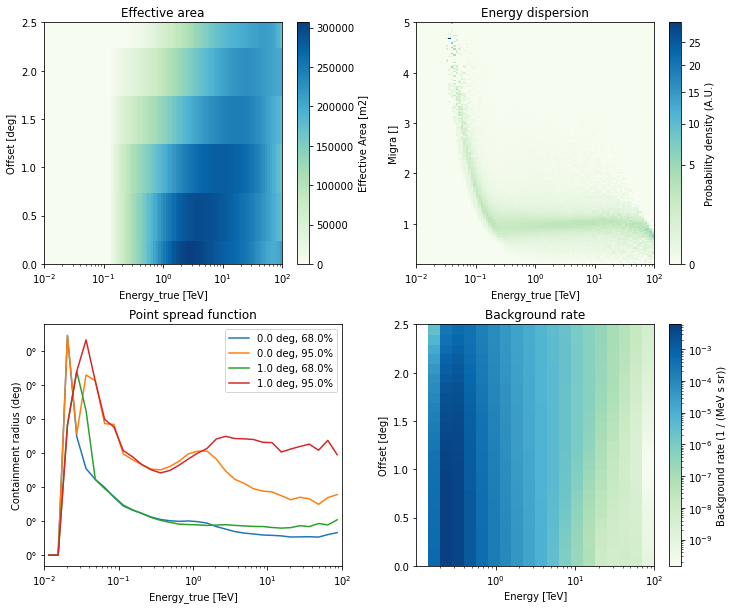

In [10]:
obs = observations[0]
obs.peek()

### Exploring event lists

The list of gamma-like events is accessible with the `Observation.events` attribute.

In [11]:
events = obs.events
print(events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 20326

  Number of events : 16880
  Event rate       : 10.030 1 / s

  Time start       : 53112.06413407407
  Time stop        : 53112.08361324074

  Min. energy      : 1.65e-01 TeV
  Max. energy      : 8.84e+01 TeV
  Median energy    : 2.78e-01 TeV

  Max. offset      : 58.5 deg



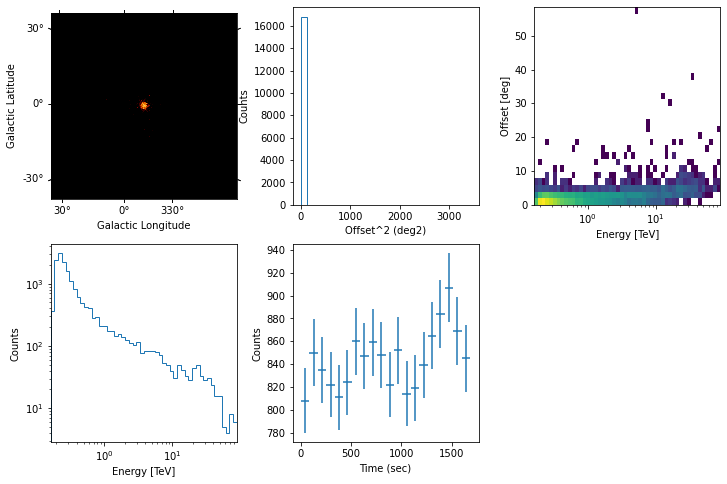

In [12]:
events.peek()

You can access directly a number of informations:

In [13]:
events.time.iso

array(['2004-04-17 01:32:21.942', '2004-04-17 01:32:22.257',
       '2004-04-17 01:32:22.275', ..., '2004-04-17 02:00:24.523',
       '2004-04-17 02:00:24.599', '2004-04-17 02:00:24.631'], dtype='<U23')

<AxesSubplot:xlabel='Energy [TeV]', ylabel='Counts'>

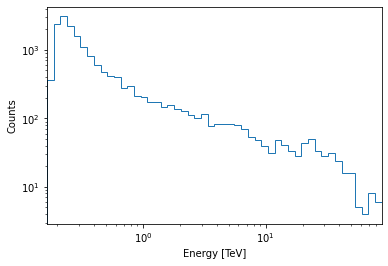

In [14]:
events.plot_energy()

It is possible to filter the event list as well. In this case, this will provide a cleaner view of the events.

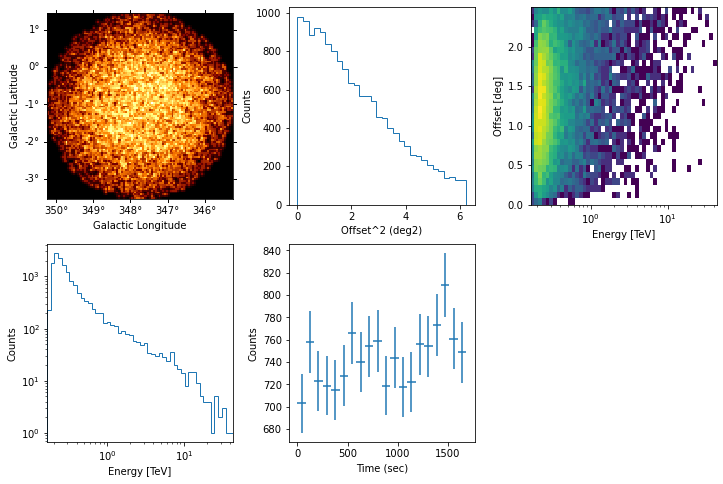

In [15]:
events.select_offset([0,2.5]*u.deg).peek()

### Accessing and exploring IRFs
You can also access all IRFs stored on the `Observation`.

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


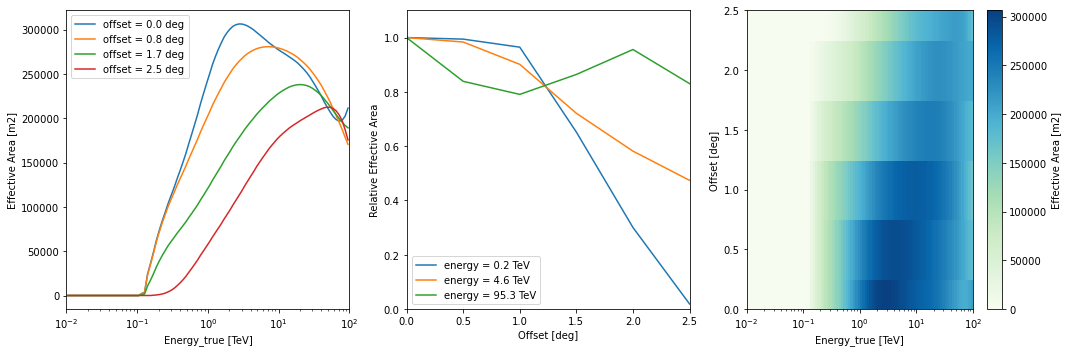

In [16]:
obs.aeff.peek()

In [17]:
print(obs.aeff)

EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (96, 6)
  ndim  : 2
  unit  : m2
  dtype : >f4



In [18]:
obs.aeff.evaluate(energy_true=20*u.TeV, offset=0.8*u.deg)

<Quantity 265838.77812203 m2>

In [19]:
print(obs.edisp)

EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (96, 160, 6)
  ndim  : 3
  unit  : 
  dtype : >f4



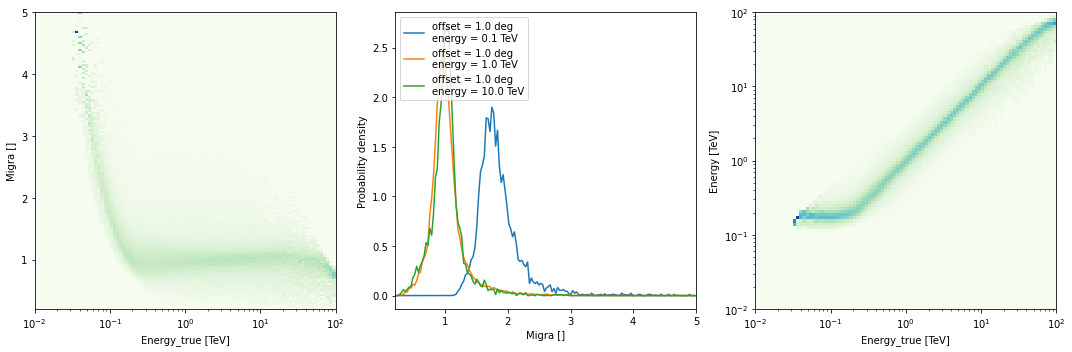

In [20]:
obs.edisp.peek()

In [21]:
print(obs.psf)

PSF3D
-----

  axes  : ['energy_true', 'offset', 'rad']
  shape : (32, 6, 144)
  ndim  : 3
  unit  : 1 / sr
  dtype : >f4



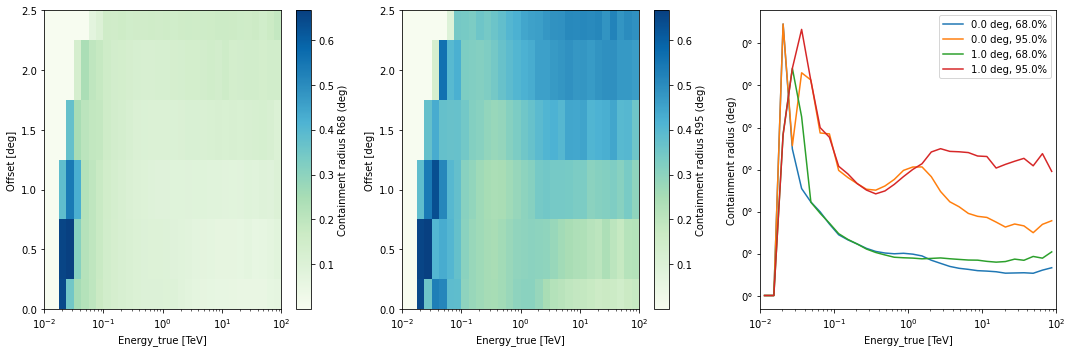

In [22]:
obs.psf.peek()

In [23]:
print(obs.bkg)

Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (20, 50, 50)
  ndim  : 3
  unit  : 1 / (MeV s sr)
  dtype : >f4



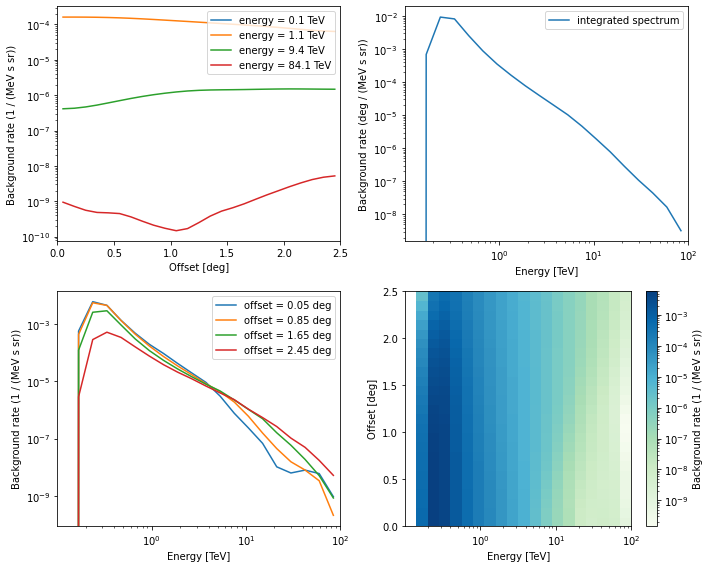

In [24]:
obs.bkg.peek()

## Preparing reduced datasets geometry
We define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [25]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(5, 5),
    frame="galactic",
    proj="TAN",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

In [26]:
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (250, 250, 15)
	ndim       : 3
	frame      : galactic
	projection : TAN
	center     : 347.3 deg, -0.5 deg
	width      : 5.0 deg x 5.0 deg
	wcs ref    : 347.3 deg, -0.5 deg



Now we can define the target dataset with this geometry.

In [27]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)

In [28]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Data reduction

### Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.

In [29]:
maker = MapDatasetMaker(selection=['counts','background', 'psf', 'edisp', 'exposure'])

In [30]:
offset_max = 2.3 * u.deg

maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

In [31]:
circle = CircleSkyRegion(
    center=target_position, radius=0.7 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [32]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

The `FoVBackgroundMaker` performs the background normalisation outside the exclusion region

### Perform the data reduction loop

In [33]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 20326: 0.99
Background norm obs 20327: 1.06
Background norm obs 20349: 0.98
Background norm obs 20350: 1.03
Background norm obs 20396: 1.01
Background norm obs 20397: 1.02
Background norm obs 20421: 1.04
Background norm obs 20422: 0.98
Background norm obs 20517: 0.99
Background norm obs 20518: 0.96
Background norm obs 20519: 0.98
Background norm obs 20521: 0.94
Background norm obs 20898: 0.95
Background norm obs 20899: 0.96
Background norm obs 20900: 0.97
CPU times: user 46.5 s, sys: 9.97 s, total: 56.5 s
Wall time: 1min


In [34]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 47103 
  Total background counts         : 45065.11
  Total excess counts             : 2037.89

  Predicted counts                : 45065.10
  Predicted background counts     : 45065.11
  Predicted excess counts         : nan

  Exposure min                    : 8.20e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 842240 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Inspect the reduced dataset

We can use the peek() method to have a brief view of the dataset content.

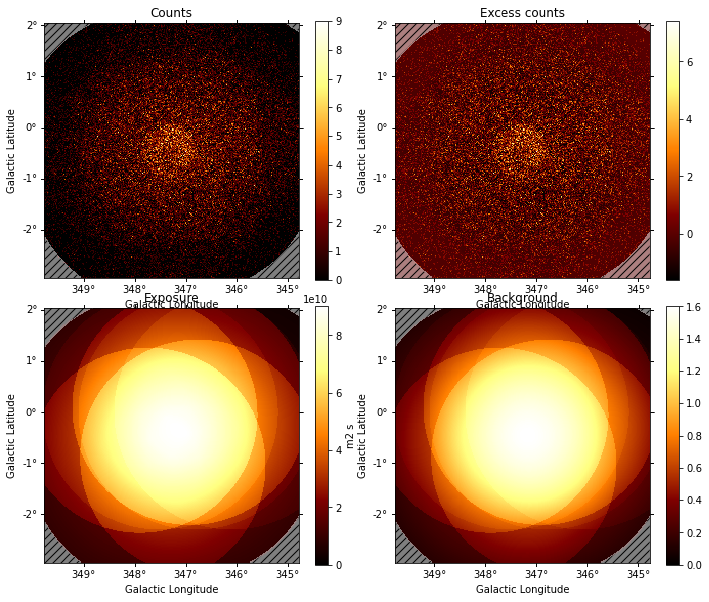

In [35]:
stacked.peek()

The dataset contains also maps of projected IRFs. See e.g. the `PSFMap`.

In [36]:
print(stacked.psf)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (25, 25, 66, 20)
	ndim  : 4
	unit  : 1 / sr
	dtype : float32



The map of `counts` can be accessed directly.

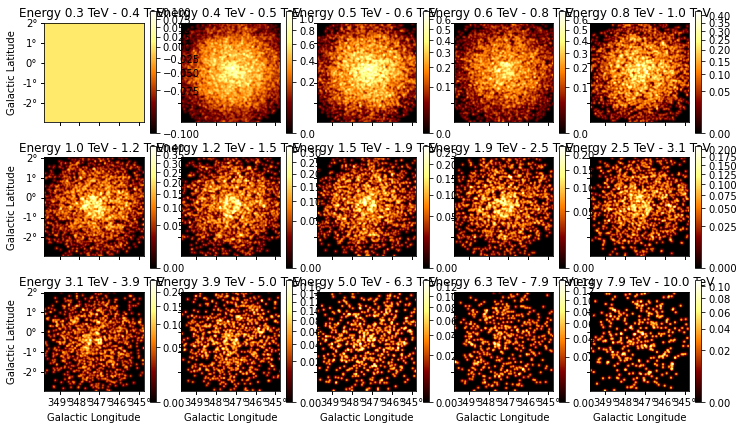

In [37]:
stacked.counts.smooth(0.04 * u.deg).plot_grid(
    stretch="sqrt", add_cbar=True, ncols=5
);

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


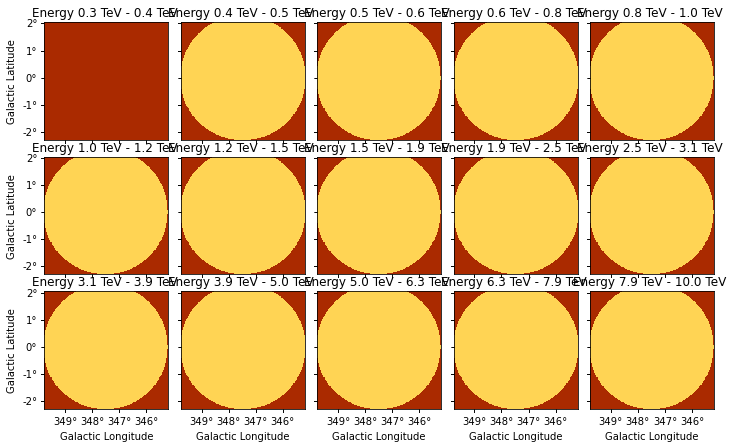

In [38]:
dataset.mask_safe.plot_grid(vmin=-1, vmax=2, ncols=5);

Save the dataset to disc using `~gammapy.datasets.MapDataset.write()` method:

In [39]:
filename = "rxj-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

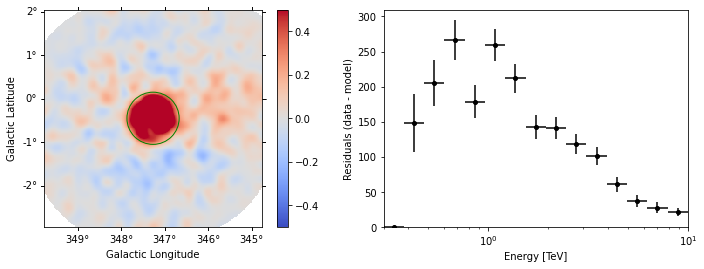

In [40]:
region = CircleSkyRegion(
    center=target_position, radius=0.6 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region}, kwargs_spatial={"vmin":-0.5, "vmax": 0.5})

In [41]:
stacked.exposure

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (250, 250, 20)
	ndim  : 3
	unit  : m2 s
	dtype : float32

At this stage, we have created a DL4 `MapDataset`. The rest of the notebook is agnostic to how this dataset was created (simulated/H.E.S.S./Fermi-LAT, etc)...

If you are interested only in the spectrum, not the morphology, you can do a 1D spectral extraction using the `SpectrumDatasetMaker`. See https://docs.gammapy.org/0.19/tutorials/index.html#d-spectral for details.

## Compute an excess and a significance map

In [42]:
stacked = MapDataset.read("rxj-stacked-dataset.fits.gz", name="msh-dataset")

In [43]:
estimator = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.4,20]*u.TeV)
maps = estimator.run(stacked)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

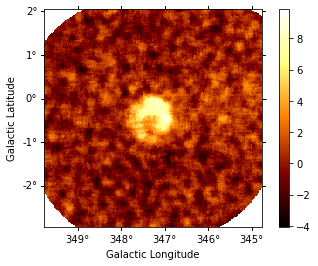

In [44]:
maps.sqrt_ts.plot(add_cbar=True)

What if you want to add significance and correlated counts maps on the same plot?
You can do it using the projection argument of matplotlib subplots.

<WCSAxesSubplot:title={'center':'Excess map'}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

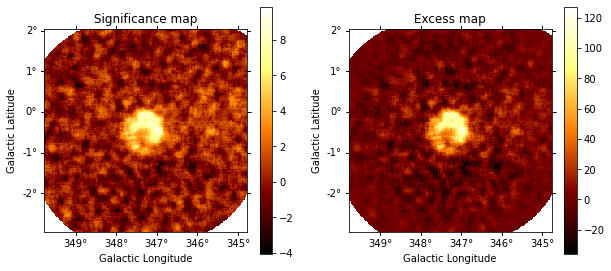

In [45]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(222, projection=maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
maps.npred_excess.plot(ax=ax2, add_cbar=True)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

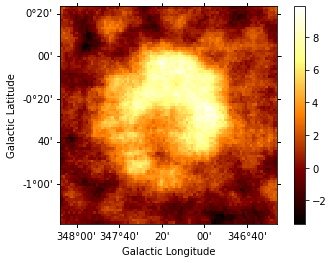

In [46]:
## You can zoom into your region
maps.sqrt_ts.cutout(position=target_position, width=1.7*u.deg).plot(add_cbar=True)

Note that the estimator also build flux maps that can accessed directly. 

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

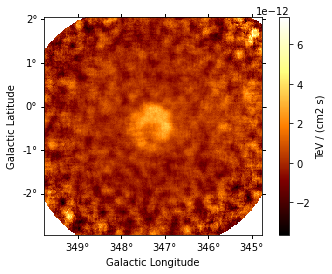

In [47]:
maps.eflux.plot(add_cbar=True)

### Excess maps in different energy bands

We can also apply the estimator in different energy bands to look for possible differences in the emission as a function of energy.
To do so, we pass `energy_edges` as an argument.
The estimator will find the energy bin closest to the required edge.

In [48]:
estimator = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 1.5, 20]*u.TeV)
maps = estimator.run(stacked)

array([<WCSAxesSubplot:title={'center':'Energy 0.4 TeV - 1.5 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
       <WCSAxesSubplot:title={'center':'Energy 1.5 TeV - 10.0 TeV '}, xlabel='Galactic Longitude'>],
      dtype=object)

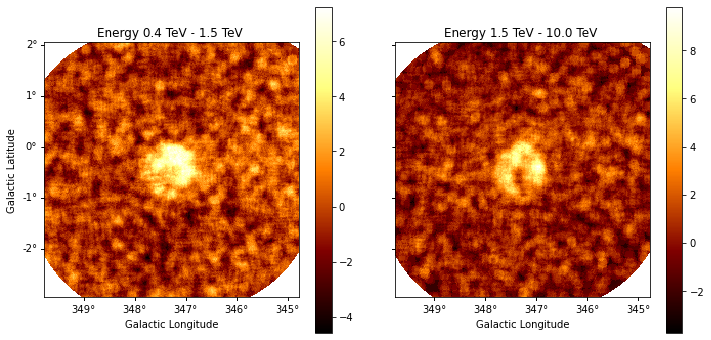

In [49]:
maps.sqrt_ts.plot_grid(add_cbar=True)

## Is the source extended? Look at the radial profiles

For details, see: https://docs.gammapy.org/0.19/tutorials/analysis/3D/flux_profiles.html

In [50]:
from gammapy.utils.regions import (
    make_concentric_annulus_sky_regions,
)
from gammapy.maps import RegionGeom
from gammapy.estimators import FluxProfileEstimator, FluxPoints

In [51]:
regions = make_concentric_annulus_sky_regions(
    center=target_position,
    radius_max="1.2 deg",
    nbin=9,
)
regions

[<CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.0 deg, outer_radius=0.15 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.15 deg, outer_radius=0.3 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.3 deg, outer_radius=0.44999999999999996 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.44999999999999996 deg, outer_radius=0.6 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.6 deg, outer_radius=0.75 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.75 deg, outer_radius=0.8999999999999999 deg)>,
 <CircleAnnulusSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (347.27, -0.45)>, inner_radius=0.8999999999999999 deg,

In [52]:
geom = RegionGeom.create(region=regions)
geom

/Users/terrier/Code/anaconda3/envs/gammapy-0.19/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


RegionGeom

	region     : CompoundSkyRegion
	axes       : ['lon', 'lat']
	shape      : (1, 1)
	ndim       : 2
	frame      : icrs
	center     : 258.3 deg, -39.8 deg

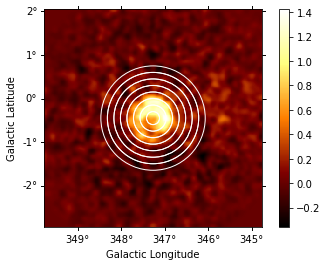

In [53]:
img = stacked.excess.sum_over_axes()
ax = img.smooth(0.06*u.deg).plot(add_cbar=True)
geom.plot_region(ax=ax, color="w");

In [54]:
flux_profile_estimator = FluxProfileEstimator(
    regions=regions,
    energy_edges=[0.5,10] * u.TeV,
)

In [55]:
%%time
profile = flux_profile_estimator.run(datasets=dataset)

CPU times: user 5.01 s, sys: 191 ms, total: 5.2 s
Wall time: 5.63 s


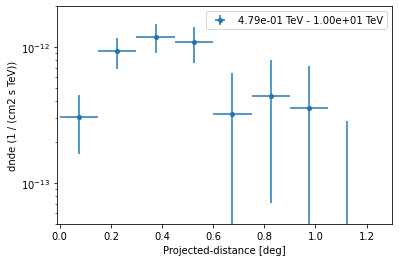

In [56]:
ax = profile.plot(axis_name="projected-distance", sed_type="dnde")
ax.set_xbound(-0.01,1.3)
ax.set_ybound(5e-14, 2e-12)

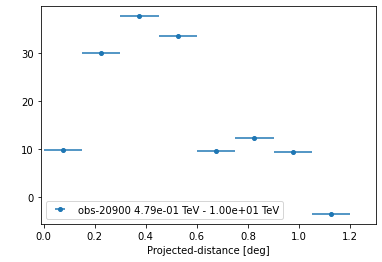

In [57]:
ax = profile.npred_excess.plot(axis_name="projected-distance")
ax.set_xbound(-0.01,1.3)